## Data Preprocessing

In [14]:
import os
import pandas as pd

def load_datasets(folder_path):
    dataframes = {}
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, low_memory=False)
            print(f"Loaded {file} with {df.shape[0]} rows and {df.shape[1]} columns")
            dataframes[file] = df
    return dataframes

def merge_datasets(dataframes):
    # Load individual datasets
    customers = dataframes.get("train_1.csv")
    geolocation = dataframes.get("train_2.csv")
    order_items = dataframes.get("train_3.csv")
    payments = dataframes.get("train_4.csv")
    reviews = dataframes.get("train_5.csv")
    orders = dataframes.get("train_6.csv")
    products = dataframes.get("train_7.csv")
    sellers = dataframes.get("train_8.csv")
    category_translation = dataframes.get("train_9.csv")

    # Step 1: Merge order-related data
    merged_df = orders
    merged_df = merged_df.merge(customers, on="customer_id", how="left")
    merged_df = merged_df.merge(order_items, on="order_id", how="left")
    merged_df = merged_df.merge(payments, on="order_id", how="left")
    merged_df = merged_df.merge(reviews, on="order_id", how="left")

    # Step 2: Merge product & seller details
    merged_df = merged_df.merge(products, on="product_id", how="left")
    merged_df = merged_df.merge(sellers, on="seller_id", how="left")
    merged_df = merged_df.merge(category_translation, on="product_category_name", how="left")

    # Step 3: Merge geolocation (based on zip codes)
    merged_df = merged_df.merge(geolocation, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")

    print(f"Final merged dataset shape: {merged_df.shape}")
    return merged_df

# Load datasets
folder_path = "./data"
dataframes = load_datasets(folder_path)

# Merge datasets
processed_data = merge_datasets(dataframes)

# Save the final cleaned dataset
output_path = "processed_data.csv"
processed_data.to_csv(output_path, index=False)

print(f"Processed dataset saved as {output_path}")


Loaded train_1.csv with 99441 rows and 5 columns
Loaded train_2.csv with 1000163 rows and 5 columns
Loaded train_3.csv with 112650 rows and 7 columns
Loaded train_4.csv with 103886 rows and 5 columns
Loaded train_5.csv with 99224 rows and 7 columns
Loaded train_6.csv with 99441 rows and 8 columns
Loaded train_7.csv with 32951 rows and 9 columns
Loaded train_8.csv with 3095 rows and 4 columns
Loaded train_9.csv with 71 rows and 2 columns
Final merged dataset shape: (18188958, 45)


PermissionError: [Errno 13] Permission denied

In [16]:
import pandas as pd

# Load dataset
df = pd.read_csv("processed_data.csv")

# Convert relevant columns to datetime
date_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "order_delivered_carrier_date"
]
df[date_cols] = df[date_cols].apply(pd.to_datetime)

# Compute delivery time features
df["actual_delivery_time"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["estimated_delivery_time"] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.days
df["delivery_delay"] = df["actual_delivery_time"] - df["estimated_delivery_time"]

# Extract time-based features
df["purchase_year"] = df["order_purchase_timestamp"].dt.year
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_day"] = df["order_purchase_timestamp"].dt.day
df["purchase_hour"] = df["order_purchase_timestamp"].dt.hour

# Save the updated dataset
df.to_csv("processed_data_with_features.csv", index=False)

print("Feature engineering complete! Data saved as 'processed_data_with_features.csv'")


Feature engineering complete! Data saved as 'processed_data_with_features.csv'


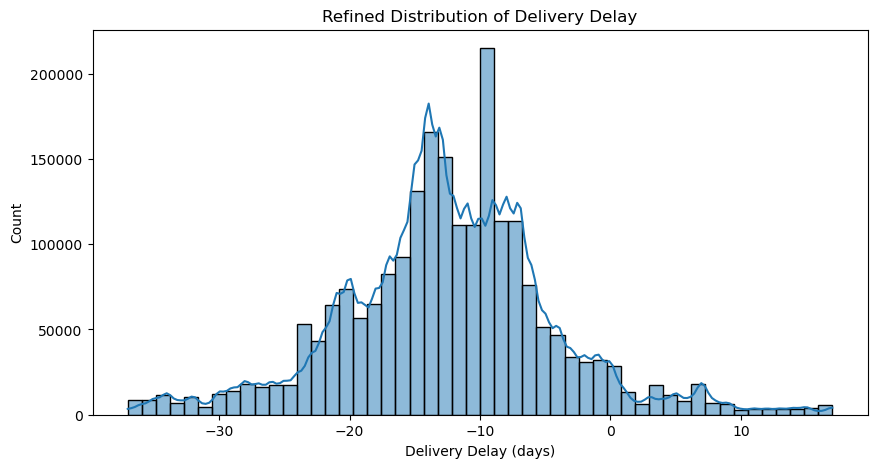

Refined dataset saved as 'refined_data_with_features.csv'.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed dataset with features
df = pd.read_csv("processed_data_with_features.csv")  # Ensure this file is in the working directory

# Convert delivery date columns to datetime format
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

# Calculate delivery delay (actual - estimated)
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

# Remove extreme outliers beyond 99th percentile
lower_bound, upper_bound = np.percentile(df['delivery_delay'].dropna(), [1, 99])
df_filtered = df[(df['delivery_delay'] >= lower_bound) & (df['delivery_delay'] <= upper_bound)]

# Plot refined data
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered['delivery_delay'], bins=50, kde=True)
plt.xlabel("Delivery Delay (days)")
plt.ylabel("Count")
plt.title("Refined Distribution of Delivery Delay")
plt.show()

# Save refined dataset
df_filtered.to_csv("refined_data_with_features.csv", index=False)
print("Refined dataset saved as 'refined_data_with_features.csv'.")
